In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Suppress logging warnings
os.environ['GRPC_VERBOSITY']= 'NONE'
os.environ['GLOG_minloglevel']= '2'
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def extract_df(path):
    labels= []
    images= []
    
    for folder in os.listdir(path):
        folderpath= os.path.join(path, folder)
        for file in os.listdir(folderpath):
            labels.append(folder)
            images.append(os.path.join(folderpath, file))
    return pd.DataFrame({
        'labels': labels,
        'images': images,
    })
    

In [3]:
df= extract_df('bonemarrow')
n_labels= len(df['labels'].unique())
df_trn, df_tst= train_test_split(df,     test_size=0.2, random_state=42,) 
df_trn, df_vld= train_test_split(df_trn, test_size=0.3, random_state=42,) 

In [4]:
IMAGE_TRGT_SIZE= (256, 256)
def df2gen(gen, df):
    return gen.flow_from_dataframe(df, x_col='images', y_col='labels', target_size=IMAGE_TRGT_SIZE,
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

In [5]:
gen=     ImageDataGenerator()
gen_aug= ImageDataGenerator(
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #sheer_range,
    zoom_range=0.5,
    #brightness_range,
    horizontal_flip=True,
    vertical_flip=True
)
gen_trn= df2gen(gen_aug, df_trn)
gen_tst= df2gen(gen, df_tst)
gen_vld= df2gen(gen, df_vld)

Found 712 validated image filenames belonging to 7 classes.
Found 269 validated image filenames belonging to 7 classes.
Found 325 validated image filenames belonging to 7 classes.


/Users/sagarkumarsahu/Desktop/all/generative_ai/YOU_TUBE/.conda/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 117 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(
/Users/sagarkumarsahu/Desktop/all/generative_ai/YOU_TUBE/.conda/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 28 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(
/Users/sagarkumarsahu/Desktop/all/generative_ai/YOU_TUBE/.conda/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 31 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


In [7]:
model_base= tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    #input_tensor=None,
    input_shape=(IMAGE_TRGT_SIZE[0], IMAGE_TRGT_SIZE[1], 3),
    #pooling=None, #'max' for flattening the image
    #classes=1000,
    #classifier_activation='softmax',
    #name='efficientnetb3',
)
model= Sequential([
    model_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense( 64, activation='relu'),
    Dense( 32, activation='relu'),
    Dense(  7, activation='softmax'),
])
model.compile(optimizer=Adamax(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
hist= model.fit(gen_trn, validation_data=gen_vld, epochs=7)

Epoch 1/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.3570 - loss: 1.9070 - val_accuracy: 0.4677 - val_loss: 1.5734
Epoch 2/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.6740 - loss: 0.9335 - val_accuracy: 0.6031 - val_loss: 1.3863
Epoch 3/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.7887 - loss: 0.6518 - val_accuracy: 0.7415 - val_loss: 0.7668
Epoch 4/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.8062 - loss: 0.5691 - val_accuracy: 0.8185 - val_loss: 0.5463
Epoch 5/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8684 - loss: 0.4012 - val_accuracy: 0.8277 - val_loss: 0.5192
Epoch 6/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.8730 - loss: 0.3754 - val_accuracy: 0.8277 - val_loss: 0.5160
Epoch 7/7
45/45 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.9028 - loss: 0.2775 - val_accuracy: 0.9108 - val_loss: 0.2540


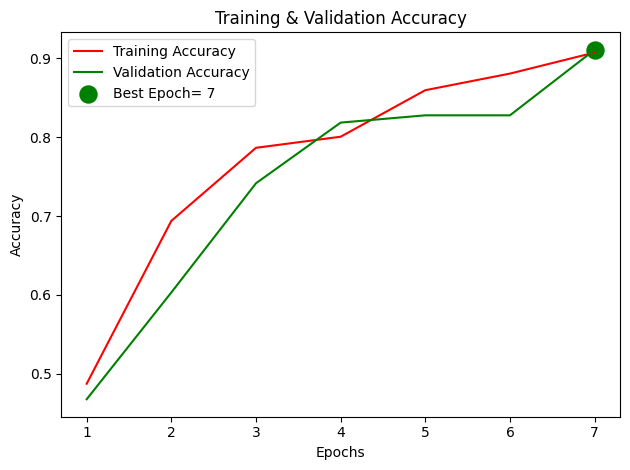

In [8]:
acc_trn= hist.history['accuracy']
acc_vld= hist.history['val_accuracy']
acc_vld_idx= np.argmax(acc_vld)
acc_vld_best= acc_vld[acc_vld_idx]
epochs= list(range(1, len(acc_trn)+1))

# plt.figure(figsize=(10, 8))
plt.plot(epochs, acc_trn, 'r', label='Training Accuracy')
plt.plot(epochs, acc_vld, 'g', label='Validation Accuracy')
plt.scatter(acc_vld_idx+1, acc_vld_best, s=150, c='green', label='Best Epoch= %d'%(acc_vld_idx+1))
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
score_trn= model.evaluate(gen_trn)
score_vld= model.evaluate(gen_vld)
score_tst= model.evaluate(gen_tst)

45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - accuracy: 0.9408 - loss: 0.1646
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - accuracy: 0.9072 - loss: 0.2758
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.8812 - loss: 0.4250


In [10]:
print(
    "%-11s Accuracy=%f, Loss=%f\n"*3%(
        'Training:',   score_trn[1], score_trn[0],
        'Validation:', score_vld[1], score_vld[0],
        'Testing:',    score_tst[1], score_tst[0],
    )
)

Training:   Accuracy=0.936798, Loss=0.177241
Validation: Accuracy=0.910769, Loss=0.254015
Testing:    Accuracy=0.888476, Loss=0.367350

